# Artificial Intelligence 

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


---
### Why We're Here 

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists. Our imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [5]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
# Here we put the dog images to a data object with the dog breed as the target and filenames as data
# This function returns the dog filenames and the targets

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
#doing item[20:-1] removes the first 20 characters in the filenames viz. the path


# print statistics about the dataset
# np.hstack does a horizontal stacking of the files 
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [6]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


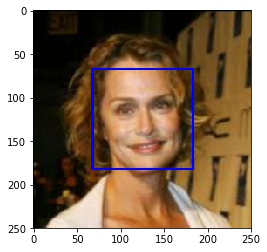

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

###  Assess the Human Face Detector

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We will see that our algorithm falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- HUMAN FILES: 98% of the human faces are detected. 
- DOG FILES: 11% of the images are detected to have human face.

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
detected_face_human = []
detected_face_dog   = []

for file in human_files_short:
    detected_face_human.append(face_detector(file))
    
for file in dog_files_short :
    detected_face_dog.append(face_detector(file))
    
print("Human Files:", sum(detected_face_human))
print("Dog Files:",sum(detected_face_dog))

Human Files: 98
Dog Files: 11


- This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face.

- While we would prefer to have clear view of the face, it seems like we could use convolution neural network to solve the problem of translational/rotational invariance. This should enable us to detect human faces even if they are not clear.

- We suggest the face detector from OpenCV as a potential way to detect human images in our algorithm, but we can explore other approaches, especially approaches that make use of deep learning :)

In [8]:
## TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
## Looks like google has something called facenet which is based on tensorflow

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
#import resnet50 model
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in our dataset!

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

#here np.expand_dims expands the dimension of the array along the axis specified.

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
#Here preprocess input does:
#1. RGB to BGR conversion
#2. Mean Normalization
#3. Returns a 4D tensor (1,H,W,Depth)
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    prediction = ResNet50_model.predict(img)
    # prediction is a (1,1000) shaped array with probabilities 
    # for each of the resnet classes
    # we will argmax function to return the class index 
    # with the highest probability
    return np.argmax(prediction)



### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

- Note that this may not be the best way to build a dog predictor, instead we could train a model on the dog label itselft. This can be done if we finetune and use transfer learning to build our model that leverages the initial stage features of the Resnet50 model.

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

###  Assess the Dog Detector

- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?



In [15]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_detected_in_dogs=[]
dog_detected_in_humans=[]
for file in human_files_short:
    dog_detected_in_humans.append(dog_detector(file))
    
dog_detected_in_humans

for file in dog_files_short:
    dog_detected_in_dogs.append(dog_detector(file))
    
print("Dogs detected in humans:",sum(dog_detected_in_humans))
print("Dogs detected in dogs:",sum(dog_detected_in_dogs))

Dogs detected in humans: 1
Dogs detected in dogs: 100


 Let us find out which of the human images we classified as dogs

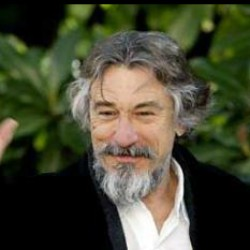

In [16]:
from IPython.display import Image
index_false_dog = np.where(dog_detected_in_humans)
Image(filename =human_files_short[index_false_dog][0])

Looks like Robert De Niro got classified as dog. 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We must create our CNN _from scratch_ (so, we would not be using transfer learning yet!), and we must attain a test accuracy of at least 1%.  In Step 5 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We need to be careful with adding too many trainable layers!  More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for our algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning. We need to experiment with many different architectures, and trust our intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras = Mean normalization
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors =  paths_to_tensor(test_files).astype('float32')/255

###  Model Architecture

We have imported some Python modules to get you started, but feel free to import as many modules as you need. Although my model is different, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
 I started with an architecture similar to the one above but made some variation. As you will notice I started with a sequential layer followed by 2 pairs of 2D convolution followed by max pooling. Added one more max pooling layer for down sampling. Finally,I flattened the inputs to the dense layer and passed the output through the softmax activation function. Using the softmax activation in the final ensures that the outcomes of this layer are probablities between (0,1) and all of the 133 probablities sum up to one. 

In [18]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 32,kernel_size=2,strides=(2,2),
                 input_shape=(224,224,3)))

model.add(MaxPooling2D(pool_size=(2,2),
                          strides=2,
                          padding='valid'))

model.add(Conv2D(filters = 64,kernel_size=2,strides=(2,2)))

model.add(MaxPooling2D(pool_size=(2,2),
                          strides=2,
                          padding='valid'))

model.add(MaxPooling2D(pool_size=(2,2),
                          strides=2,
                          padding='valid'))

model.add(Flatten())
#model.add(global_average_pooling)
model.add(Dense(133,activation='softmax'))


### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 32)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               417221    
Total para

Thanks to Geoffrey Hinton for the rmsprop optimization. 
#### RMSprop 
This optimizer only looks at the sign of the gradient and not the actual magnitude of the gradient while making the adjustment. We can think of this method as dividing the gradient by the moving average of the most recent gradients. This method is an adaptive weight optimizer meaning the weights of the gradient get adjusted iteratively. Especially when we are using mini-batch learning it does not make sense to use a global learning rate. 

- The main reason why this method is more robust is that we are not updating the gradient for each mini batch seperately. Instead we are using the moving average to make the weight updates.
- We could also try Rmsprop optimizer with momentum although Geoffrey Hinton mentions that further researh is needed to verify this improvement on Rmsprop.

### Compile the Model

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

###  Train the Model

Train our model below.
We will use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [2]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.

epochs = 4

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Using TensorFlow backend.


NameError: name 'model' is not defined

### Load the Model with the Best Validation Loss

In [20]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [21]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 8.7321%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we should now see how to train a CNN using transfer learning.  In the following step, we will  use transfer learning to train our own CNN.

### Obtain Bottleneck Features

In [22]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16  = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [23]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [24]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [26]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.5548 - acc: 0.1148 - val_loss: 11.1241 - val_acc: 0.2024
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.5233 - acc: 0.2638 - val_loss: 10.4905 - val_acc: 0.2671
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.9767 - acc: 0.3257 - val_loss: 10.0590 - val_acc: 0.2934
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.5325 - acc: 0.3602 - val_loss: 9.8047 - val_acc: 0.3090
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.1179 - acc: 0.3916 - val_loss: 9.5020 - val_acc: 0.3305
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.9104 - acc: 0.4147 - val_loss: 9.4465 - val_acc: 0.3473
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.7636 - acc: 0.4280 - val_loss: 9.1992 - val_acc: 0.3545
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.4961

### Load the Model with the Best Validation Loss

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [26]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.0191%


### Predict Dog Breed with the Model

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [28]:
#Test the Vgg model 
VGG16_predict_breed("./lfw/Al_Pacino/Al_Pacino_0001.jpg")

'Dogue_de_bordeaux'

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we will use the bottleneck features from a different pre-trained model.  To make things easier, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [22]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet50 = bottleneck_features['train']
valid_resnet50 = bottleneck_features['valid']
test_resnet50  = bottleneck_features['test']

###  Model Architecture

I have used the Resnet50 pretrained model with a global average pooling layer in the end. The model is fine tuned in the last layer to make predictions on the 133 categories of dogs. The last fine tuning layer is a dense layer with softmax activation to ensure that the probablities for the 133 categories are between [0,1] and they add up to 1.

Resnet stands for residual network. Resnet is a pretty good model for this problem. The trend we see nowadays is that deeper models perform better in general. Also Resnet provides a way of fitting the model similar to gradient boosting where the model is fitted to the residuals to sinificantly improve performance. Few advantages of Resnet are as follows:
1. Faster training speed
2. Deeper network instead of wider network means less parameters to train
3. Resnet architecture reduces the vanishing gradient problem, so weak signals are not lost in hidden networks



In [25]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the model

In [26]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model

In [22]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_resnet50, train_targets, 
          validation_data=(valid_resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6119 - acc: 0.6037 - val_loss: 0.8280 - val_acc: 0.7401
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4359 - acc: 0.8648 - val_loss: 0.6723 - val_acc: 0.7868
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2592 - acc: 0.9190 - val_loss: 0.6227 - val_acc: 0.8108
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1800 - acc: 0.9440 - val_loss: 0.6717 - val_acc: 0.8024
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1199 - acc: 0.9626 - val_loss: 0.6564 - val_acc: 0.8108
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0851 - acc: 0.9731 - val_loss: 0.6705 - val_acc: 0.8228
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0607 - acc: 0.9814 - val_loss: 0.6939 - val_acc: 0.8228
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0446 - ac

###  Load the Model with the Best Validation Loss

In [27]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [28]:
###  Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.8612%


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, our function will have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

   format extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    print(dog_names[np.argmax(predicted_vector)])
    return Image(img_path)

Beagle


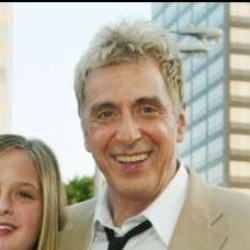

In [32]:
##Test the predictions 
Resnet50_predict_breed("./lfw/Al_Pacino/Al_Pacino_0003.jpg")

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### Write your Algorithm

In [33]:

def detect_human_dog(image_path):
        
        if dog_detector(image_path)==1:
            print("Dog Detected is of breed:",Resnet50_predict_breed(image_path))
            return Image(filename = image_path)

        elif face_detector(image_path)==1:
            print("Human Detected in the image resembles dog breed:",Resnet50_predict_breed(image_path))  
            return Image(filename = image_path)
        else:
            print("ERROR: Neither Human nor Dog detected in the image")
            return Image(filename = image_path)




---
<a id='step7'></a>
## Step 7: Test Your Algorithm



### Test Your Algorithm on Sample Images!


 The output is better than I had expected. Except one,  all the examples the model is able to detect whether it is a human or a dog. The model correctly classifies the breed of the dog which is hard even for humans.
Three ways to improve the algorithm 
1. As Resnet is a pretty complex deep learning structure, I would say adding dropouts between hidden layers would certainly help in better regularisation. 
2. I am using a global max pooling layer before the final dense layer. Max pooling is similar to downsamling in statistics. My assumption is that there is some information loss in this layer.  
3. Lastly, in terms of the data we have not used any image augmentation ie. techniques such as translating a few pixels, rotating the image, scaling, inserting random negetives in the images would certainly help as well.


Human Detected in the image resembles dog breed: Beagle


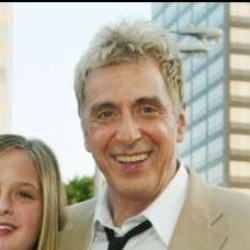

In [100]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
detect_human_dog("./lfw/Al_Pacino/Al_Pacino_0003.jpg")

Dog Detected is of breed: Afghan_hound


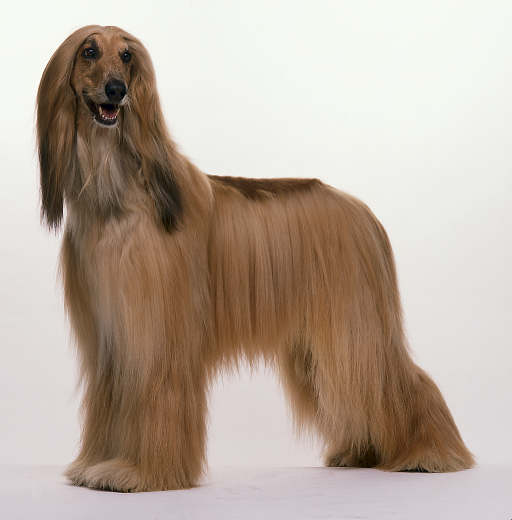

In [101]:
detect_human_dog("dogImages/train/002.Afghan_hound/Afghan_hound_00083.jpg")

In [85]:
#DogImages
image_Poodle='dogImages/train/124.Poodle/Poodle_07899.jpg'
image_American_eskimo_dog = 'dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00397.jpg'
image_Bulldog = 'dogImages/train/040.Bulldog/Bulldog_02810.jpg'

In [86]:
#HumanImages 
image_Winona_Ryder = 'lfw/Winona_Ryder/Winona_Ryder_0001.jpg'
image_John_Snow = 'lfw/John_Snow/John_Snow_0001.jpg'
image_Brad_Pitt = 'lfw/Brad_Pitt/Brad_Pitt_0001.jpg'

ERROR: Neither Human nor Dog detected in the image


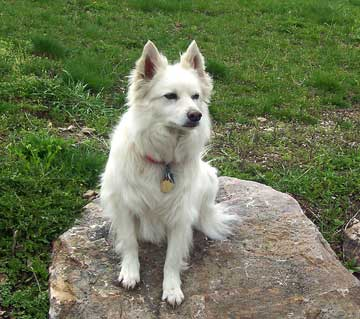

In [96]:
detect_human_dog(image_American_eskimo_dog)

Dog Detected is of breed: Bulldog


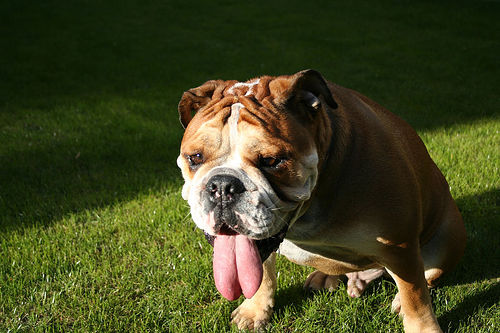

In [103]:
detect_human_dog(image_Bulldog)

Looks like the model was not able to detect the Poodle. It did detect the other images correctly and was able to predict the breed accurately. Let us see how our poodle image looks like and if it is difficult even for us to detect a dog.

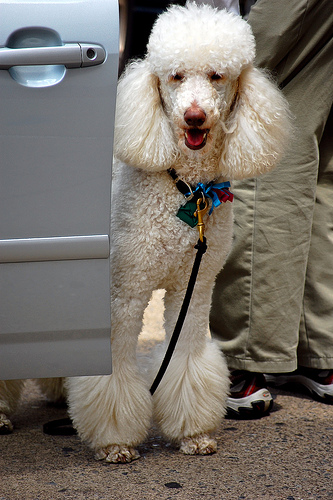

In [90]:
Image(image_Poodle)

Even though this does not look like a regular dog, the model should have been able to classify it accurately.Also note the car door in the image blocks off part of the image. This might have confused the model.

Human Detected in the image resembles dog breed: American_water_spaniel


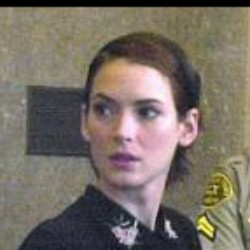

In [91]:
detect_human_dog(image_Winona_Ryder)

Human Detected in the image resembles dog breed: Ibizan_hound


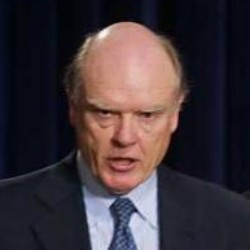

In [92]:
detect_human_dog(image_John_Snow)

Human Detected in the image resembles dog breed: English_toy_spaniel


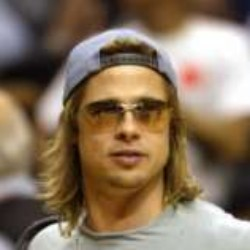

In [93]:
detect_human_dog(image_Brad_Pitt)